<a href="https://colab.research.google.com/github/Anweshasen98/UAV-Object-Detection-Transfer-Learning_YOLOv3/blob/main/Custom_Object_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Custom Object Detection Model**

# Loading Images and Labels Subplot

In [ ]:
#Immport necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16 #imports the VGG16 model from the keras.applications module.
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.models import Model
from keras.optimizers import Adam
import PIL.Image as Image
import os
from PIL import Image
from sklearn import metrics
from sys import builtin_module_names


In [ ]:
#Mount Google Drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists


In [ ]:
#Create Folders, Paths and Lists for Images and Labels

#IMAGES
image_path = "/content/gdrive/MyDrive/yolov4/image"  # IMAGE FOLDER LOCATION
image_files = os.listdir(image_path) # LIST OF ALL IMAGES (not paths)

#LABELS
label_path = "/content/gdrive/MyDrive/yolov4/label" #LABEL FOLDER LOCATION
label_files = os.listdir(label_path) ## LIST OF ALL Labels (not paths)

# LIST HAVING FULL PATH OF IMAGES AND LABELS
image_list = []
label_list = []
for label_name in os.listdir(label_path):
  for image_name in os.listdir(image_path):
      if label_name[:-4] == image_name[0:-4]:
        image_list.append(image_name)
        label_list.append(label_name)

#Create image list and label list

image_list = [os.path.join(image_path, filename) for filename in image_list]
label_list = [os.path.join(label_path, filename) for filename in label_list]

# CONVERT LABELS TO APPROPRIATE FORMAT FOR cv2.rectangle()

In [ ]:
# Convert labels from [Class_Id, Xmin, Ymin, Width, Height] to [Xmin, Ymin, Xmax, Ymax]
#cv2.rectangle() needs labels in this format: [Xmin, Ymin, Xmax, Ymax]

#go through the label_list having paths of all labels, removing string and newline
#removing gaps " ", class_id and making the values float

labels = []
for label_file in label_list:
  with open(label_file, 'r') as f:
    label_data = f.read().strip().splitlines()
    for line in label_data:
      stripped_line = line.strip().split()
      stripped_line = [float(x) for x in stripped_line[1:]]
      labels.append(stripped_line)

#It will give array of labels by converting labels to numpy array.
labels = np.array(labels)  #

# Convert the labels data to xmin, ymin, xmax, ymax format
#Xmin = labels[:, 0]
#Ymin = labels[:,1]
#Width = labels[:, 2]
#Height= labels[:,3]

#Xmax= Xmin + Width = labels[:,0]+labels[:,2]
#Ymax =Ymin +Height = labels[:,1]+labels[:,3]

labels[:, 2] += labels[:, 0]
labels[:, 3] += labels[:, 1]




In [ ]:
labels

array([[150. , 104. , 312. , 169. ],
       [ 97. ,  50. , 404. , 268. ],
       [ 58. ,  55. , 372. , 191. ],
       ...,
       [ 42. , 123. , 248. , 221. ],
       [220. , 100. , 358. , 184. ],
       [ 40. ,  94.5, 344. , 233.5]])

In [ ]:
#Create a List Having all Images and rectangle with bounding boxes

list_uav = []

for image_file, label in zip(image_list, labels):
  image = cv2.imread(image_file)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #Convert images to RGB Format
  xmin, ymin, xmax, ymax = label        #Label values
  cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)
  list_uav.append(image)

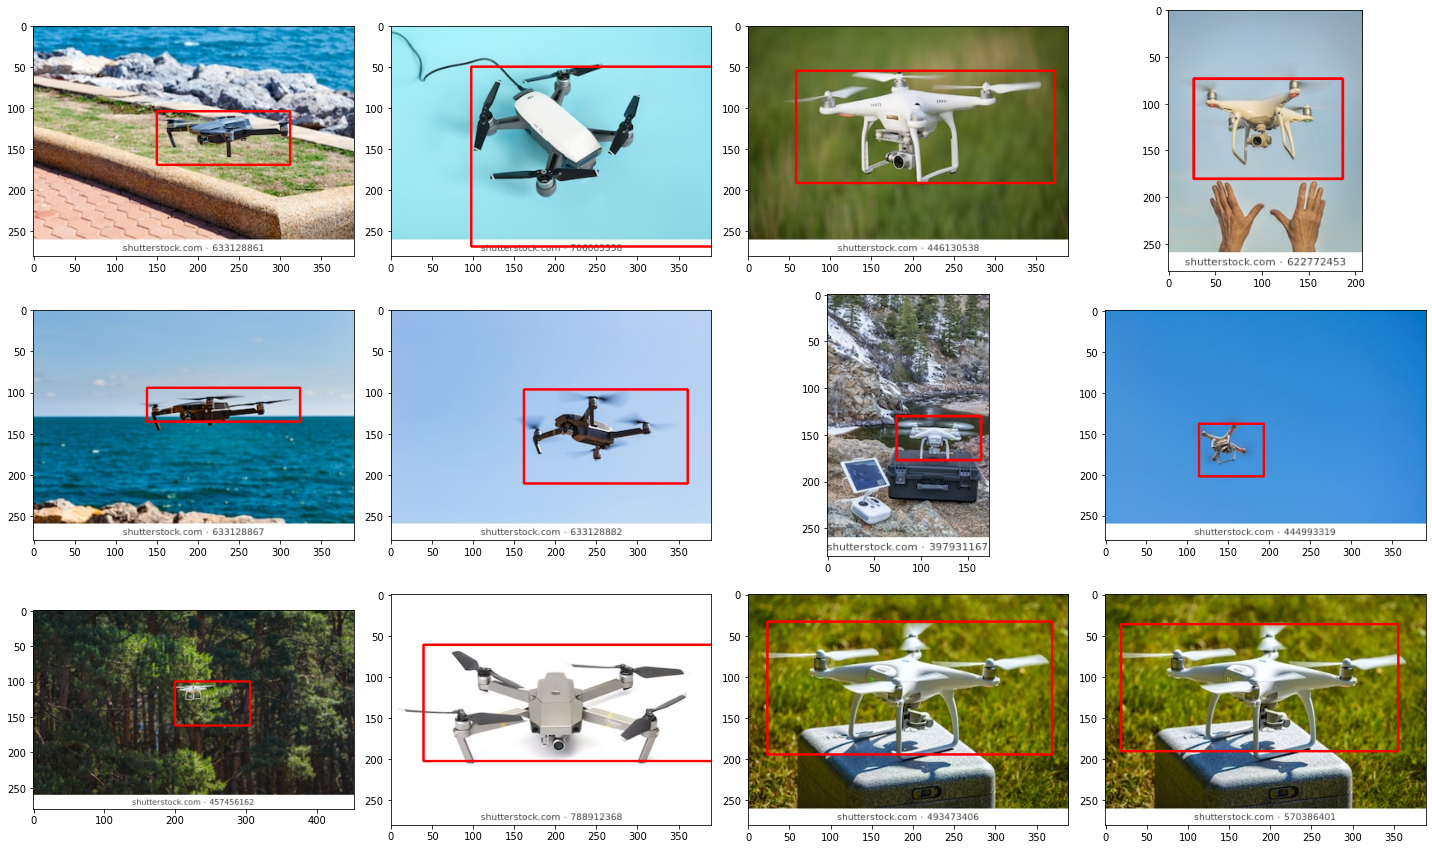

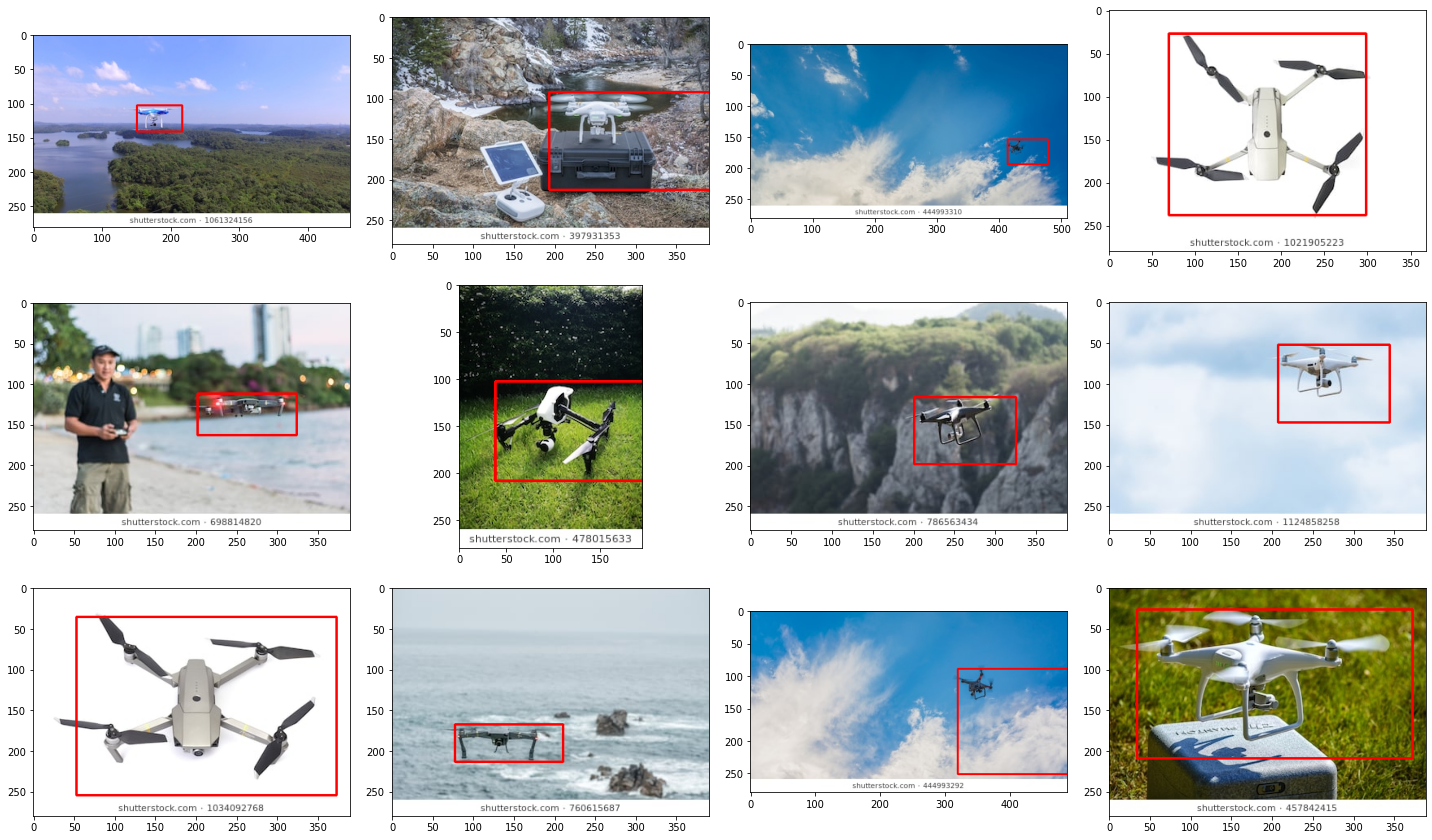

In [ ]:
#Plot Images and Labels

m = 3
n = 4
for i in range(0, 20, m*n):
    fig = plt.figure(figsize =(20,12))
    for j in range(0, m*n):
        if (i+j) < len(list_uav):
            fig.add_subplot(m,n,j+1)
            plt.imshow(list_uav[i+j])
            plt.axis('on')
    plt.tight_layout()
    plt.show()


Now, Labels are correctly plotted on images.
End of Task 2a Part 1

# **SPLITTING DATASET FOR TRAINING AND TESTING**

In [ ]:
from sklearn.model_selection import train_test_split

X = list_uav # list of all images
y = labels # list of all labels

#Taking first 32 images and Labels
X_true=list_uav[:32]
y_true=labels[:32]

#Splitting in the ratio of 90% for training and 10% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

282
282
32
32


 MODEL A: Custom Object Detection Model Using VGG16

# PREPROCESSING TRAINING AND TESTING IMAGES AND LABELS

In [ ]:
#IMAGES

from keras.applications.vgg16 import preprocess_input

# Preprocessing the training images
X_train = [cv2.resize(image, (224, 224)) for image in X_train] #Resize to 224x224 pixels
X_train = [np.array(image, dtype=np.float32) for image in X_train] #Convert to Float
X_train = preprocess_input(np.array(X_train))   #Preprocess for VGG16
X_train = X_train/255 #Normalizing by dividing with 255

# Preprocessing the test images
X_test = [cv2.resize(image, (224, 224)) for image in X_test]  #Resize to 224x224 pixels
X_test = [np.array(image, dtype=np.float32) for image in X_test] #Convert to Float
X_test = preprocess_input(np.array(X_test)) #Preprocess for VGG16
X_test = X_test/255  #Normalizing by dividing with 255

In [ ]:
# LABELS

# convert labels to float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

shapes = []
for image in list_uav:
    shape = image.shape
    shapes.append(shape)

IMG_WIDTH = shapes[0][1]
IMG_HEIGHT = shapes[0][0]

# Normalize the labels to the range 0 to 1
y_train[:, [0, 2]] /= IMG_WIDTH
y_train[:, [1, 3]] /= IMG_HEIGHT
y_test[:, [0, 2]] /= IMG_WIDTH
y_test[:, [1, 3]] /= IMG_HEIGHT

Load Pre-trained VGG16 Model

In [ ]:
# Load the VGG16 model and remove the final fully connected layers
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(224, 224, 3))

output = vgg16.layers[-1].output

output= GlobalAveragePooling2D()(output)  #GlobalAveragePooling layer
output = Flatten()(output)     #Flatten Layer

vgg16 = Model(vgg16.input, output)

In [ ]:
# Freeze the layers up to a specific layer
for layer in vgg16.layers:
    layer.trainable = False


In [ ]:
# Add new fully connected layers

x = vgg16.output
x = Dense(1024, activation='relu')(x)   #First Dense Layer
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)    #Second Dense Layer
x = Dropout(0.5)(x)
x = Dense(4, activation='linear')(x)     #Output Layer

#Dropout layers are added to the model, which randomly
#drops out a certain percentage of neurons during training to prevent overfitting.



In [ ]:
# Define the full model
model = Model(inputs=vgg16.input, outputs=x)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
#Model Compilation

model.compile(
    optimizer='adam',
    loss='mse',
    metrics ='accuracy')

In [ ]:
#Model Fitting

training = model.fit(
    X_train,y_train,
     validation_split = 0.1,
    epochs=300)

Epoch 1/300
8/8 [==============================] - 10s 595ms/step - loss: 0.5591 - accuracy: 0.3794 - val_loss: 0.0833 - val_accuracy: 0.7586
Epoch 2/300
8/8 [==============================] - 1s 176ms/step - loss: 0.1040 - accuracy: 0.5296 - val_loss: 0.0342 - val_accuracy: 0.7586
Epoch 3/300
8/8 [==============================] - 1s 175ms/step - loss: 0.0694 - accuracy: 0.5929 - val_loss: 0.0659 - val_accuracy: 0.5172
Epoch 4/300
8/8 [==============================] - 1s 177ms/step - loss: 0.0504 - accuracy: 0.5929 - val_loss: 0.0311 - val_accuracy: 0.7586
Epoch 5/300
8/8 [==============================] - 1s 176ms/step - loss: 0.0441 - accuracy: 0.5968 - val_loss: 0.0522 - val_accuracy: 0.7586
Epoch 6/300
8/8 [==============================] - 1s 178ms/step - loss: 0.0387 - accuracy: 0.5810 - val_loss: 0.0319 - val_accuracy: 0.7931
Epoch 7/300
8/8 [==============================] - 1s 178ms/step - loss: 0.0399 - accuracy: 0.5573 - val_loss: 0.0351 - val_accuracy: 0.7931
Epoch 8/300


# PERFORMANCE EVALUATION

In [ ]:
#Measure Loss and Accuracy

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss : {loss}, \nAccuracy: {accuracy}')

1/1 [==============================] - 0s 175ms/step - loss: 0.0121 - accuracy: 0.7812
Loss : 0.012094084173440933, 
Accuracy: 0.78125


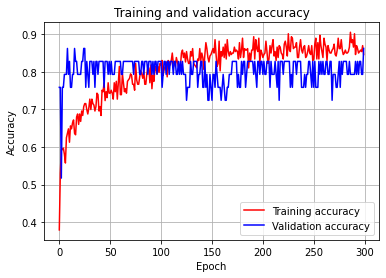

<Figure size 432x288 with 0 Axes>

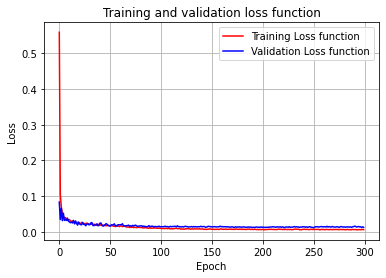

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Training and Testing curves

import matplotlib.pyplot as plt

history = training.history

def summarize_diagnostics(history):
  acc = history['accuracy']
  loss = history['loss']
  val_acc = history['val_accuracy']
  val_loss = history['val_loss']

  epochs = range(len(acc))


  plt.grid()
  plt.plot(acc, 'r', label='Training accuracy')
  plt.plot(val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.figure()
  plt.show()

  plt.grid()
  plt.plot(loss, 'r', label='Training Loss function')
  plt.plot(val_loss, 'b', label='Validation Loss function')
  plt.title('Training and validation loss function')
  plt.legend(loc=0)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.figure()
  plt.show()


summarize_diagnostics(history)

# Plot Predicted Images

In [ ]:

predicted_label = model.predict(X_test)   #prediction of test data
i = 0;
red_color = (255,0,0)
blue_color = (0,0,255)
t = 2

detected_images = []
for sample in X_test:

  img = X_true[i]

  predicted_label[i] *= [img.shape[1], img.shape[0], img.shape[1], img.shape[0]] #predicted labels
  y_true[i] *= [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]  #true labels

  truth_pair1 = (int(y_test[i][0]),int(y_test[i][1])) # Extracting x_min,y_min from test data
  truth_pair2 = (int(y_test[i][2]),int(y_test[i][3])) # Extracting x_max,y_max from test data

  detected_pair1 = (int(predicted_label[i][0]),int(predicted_label[i][1])) # Extracting x_min,y_min from predicted labels
  detected_pair2 = (int(predicted_label[i][2]),int(predicted_label[i][3])) # Extracting x_max,y_max

  tru_label_img = cv2.rectangle(img,truth_pair1,truth_pair2,red_color,t)
  final_img = cv2.rectangle(tru_label_img, detected_pair1,detected_pair2,blue_color,t)
  detected_images.append(final_img) # Storing annotated images in list

  i = i+1;


1/1 [==============================] - 0s 173ms/step


IndexError: ignored

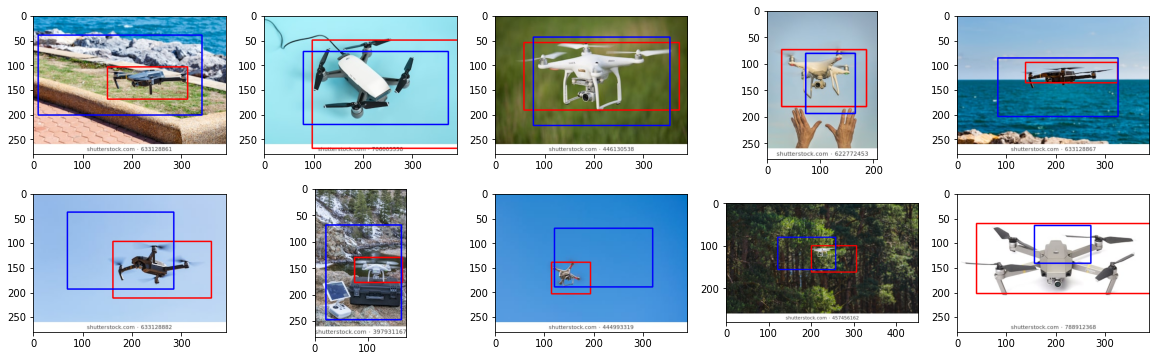

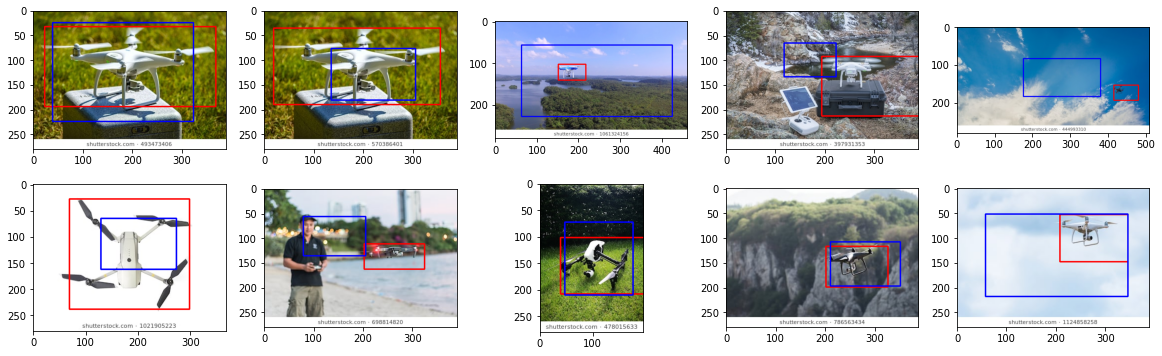

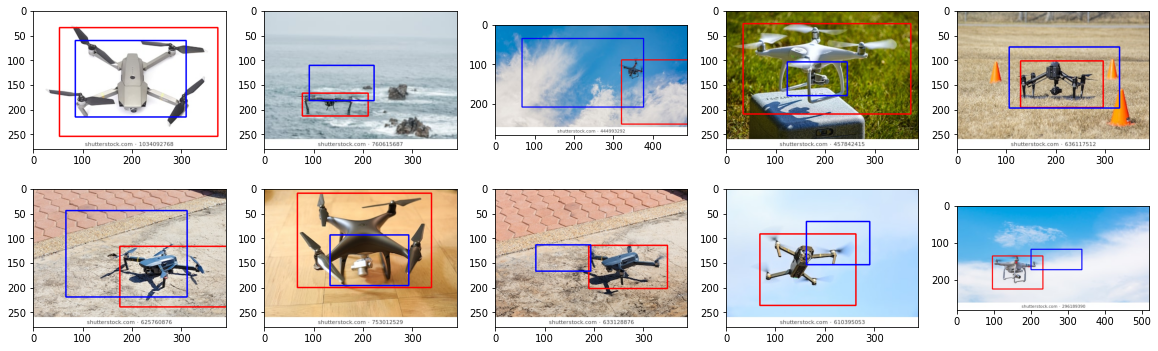

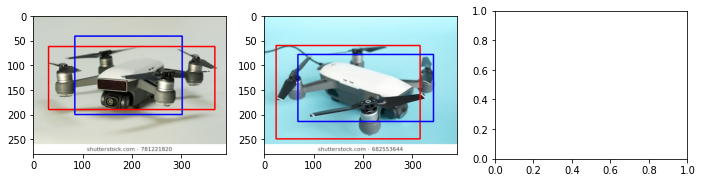

In [ ]:
#Plot
m =2
n = 5
for i in range(0,len(detected_images),m*n):
    fig = plt.figure(figsize =(20,6))
    for j in range(0, m*n):
        fig.add_subplot(m,n,j+1)
        plt.imshow(detected_images[i+j])

